#### Problem Statement

S Ltd is bringing the new brand Cc, they are required to acquired 100 accounts within 5 days. From the transaction records provided, potential customers with the possibility of purchasing in short term need to be identified. Unsupervised data given, segmenting the customers into k clusters and find the cluster that is most possible to have interest in the new brand. 

#### Dataset

Dataset.csv - Transaction records from January 2018 to December 2019

#### Library Loading

In [1]:
from io import StringIO
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D
import os

#### Data Loading

In [2]:
print('Loading Data ...')
data = pd.read_csv('C:/Users/Hshan/Desktop/data.csv')
display(data.head())
print('Loading Completed ...')

Loading Data ...


,Transaction Date,Customer Id,Sales Agent ID,Invoice ID,Credit Term,Customer Name,Order ID,SKU Name,SKU Code,Brand,Category,Quantity,Sales Amount
0,02/01/2018,101347,21LW2,310189261,14,FONG,326895,F&N TEH TARIK POUCH 2.5KGX8,1111528,F&N,CULINARY,4,360.40
1,02/01/2018,101347,21LW2,310189261,14,FONG,326895,GOLD COIN EVAP CREAMER 390GX48,1111965,GOLD,DAIRY,4,453.68
2,02/01/2018,101354,21LW3,8241019825,0,ONN,326931,TIGER 660ML-D QTS (1X12)-CRT [F18 CNY],400975,TIGER,ALCHOHOLIC BEVERAGE,4,643.63
3,02/01/2018,101354,21LW3,8241019825,0,ONN,326931,Crate Own TIGER 12x660ml MY,500014,ACCESSORIES,ACCESSORIES,4,28.00
4,02/01/2018,101354,21LW3,8241019825,0,ONN,326931,RB Own Amber TIGER 660ml MG901-01 Emb PO,500112,R-ALCOHOLBEV,REBATE ITEMS,4,14.40


Loading Completed ...


#### Data Exploration

In [3]:
sum_nan = 0
for col in list(data.columns):
    if any(data[col].isnull()):
        sum_nan += 1
print('--- Checking for NULL ---')
print(f'There is {sum_nan} NUll value(s)')

--- Checking for NULL ---
There is 0 NUll value(s)


In [4]:
print('--- Dimension of Data ---')
print()
print('Number of Records: ', data.shape[0])
print('Number of Features: ', data.shape[1])
print()

print('--- Information about Data ---')
print()
data.info()

--- Dimension of Data ---

Number of Records:  119737
Number of Features:  13

--- Information about Data ---

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119737 entries, 0 to 119736
Data columns (total 13 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Transaction Date  119737 non-null  object 
 1   Customer Id       119737 non-null  int64  
 2   Sales Agent ID    119737 non-null  object 
 3   Invoice ID        119737 non-null  object 
 4   Credit Term       119737 non-null  int64  
 5   Customer Name     119737 non-null  object 
 6   Order ID          119737 non-null  int64  
 7   SKU Name          119737 non-null  object 
 8   SKU Code          119737 non-null  object 
 9   Brand             119737 non-null  object 
 10  Category          119737 non-null  object 
 11  Quantity          119737 non-null  int64  
 12  Sales Amount      119737 non-null  float64
dtypes: float64(1), int64(4), object(8)
memory usage: 11.9

In [5]:
print('--Listing Features ---')
print()
data_features = list(data.columns)
print(data_features)

--Listing Features ---

['Transaction Date', 'Customer Id', 'Sales Agent ID', 'Invoice ID', 'Credit Term', 'Customer Name', 'Order ID', 'SKU Name', 'SKU Code', 'Brand', 'Category', 'Quantity', 'Sales Amount']


In [6]:
data.Category.unique()

array(['CULINARY', 'DAIRY', 'ALCHOHOLIC BEVERAGE', 'ACCESSORIES',
       'REBATE ITEMS', 'SUGARY DRINKS', 'MINERAL WATER', 'ENERGY DRINKS',
       'GIFTS'], dtype=object)

In [7]:
data[data.Category=='CULINARY']['SKU Name']

0                   F&N TEH TARIK POUCH 2.5KGX8
11                          F&N STRW 325ML12CAN
24                    F&N SEASONS CHRYTEA 1LTTP
27                         F&N SEASONS SB 1LTTP
28                  F&N I/C SODA 325ML12CAN (S)
                          ...                  
119664          F&N GINGERL (A) PET 1.2LX12 POP
119665    F&N SEASONS ICE PEACH T ASP PET 1LX12
119666              F&N ORANGE (ST) PET 1.2LX12
119667    F&N SS WMELON LYCHEE ASP PET 380MLX24
119668                 F&N SS SB (ST) TTP 1LX12
Name: SKU Name, Length: 33983, dtype: object

Most of the features provided are identity information, which provide not much information on the features of a particular products. Exploration is done on [Category, Transaction Date, Brand, Category, Sales Amount]. 

Going through the list of products in CULINARY, it is obviously some of the drinks are categorized as CULINARY, instead of SUGARY DRINKS. Considering the products by Coca Cola, they are mainly in the category of 'SUGARY DRINKS', 'CULINARY', and probably 'REBATE ITEMS. Extracting the data from the categories specified. 

Filtering the list of CULINARY and REBATE ITEMS products, there are brand that do not produce drinks, records for those brands from the extracted data. 

In [8]:
data_cat = data[data.Category.isin(['CULINARY','SUGARY DRINKS','REBATE ITEMS'])]
culi_brand = ['INDOMIE','CARNATION ', 'SUPERSAVER ']
data_cat = data_cat[~data_cat.Brand.isin(culi_brand)]

print('Rebate Items Brands: ', data_cat[data_cat.Category=='REBATE ITEMS'].Brand.unique(), sep = '\n')
print()

data_cat[(data_cat.Category=='REBATE ITEMS') & (data_cat.Brand=='R-F&N ')]['SKU Name'].unique()

data_cat = data_cat[data_cat.Category!='REBATE ITEMS']

print('Shape of Dataset Extracted: ', data_cat.shape)

Rebate Items Brands: 
['R-ALCOHOLBEV' 'R-TEAPOT ' 'R-GOLD ' 'R-CAP ' 'R-CARNATION ' 'R-F&N '
 'R-IDEAL ']

Shape of Dataset Extracted:  (50515, 13)


Transforming data type of 'Transaction Date' column for RFM analysis. New features, recency, frequency, monetary value are created and vizualized. 

In [9]:
data_cat['Transaction Date'] = data_cat['Transaction Date'].apply(pd.to_datetime)
data_cat['Transaction Date'] = data_cat['Transaction Date'].dt.date

rec_end = max(data_cat['Transaction Date']) + dt.timedelta(days=1)
rfm_df = data_cat.groupby('Customer Id').agg({'Transaction Date': lambda x: (rec_end-max(x)).days,
                       'Invoice ID': 'count',
                       'Sales Amount': 'sum'})
rfm_df.columns = ['Recency', 'Frequency', 'Monetary']
display(rfm_df.head())

,Recency,Frequency,Monetary
Customer Id,,,
98531,15,514,29848.82
98553,23,16,785.63
98568,9,78,3747.00
98570,15,404,12855.08
98573,41,225,38109.47


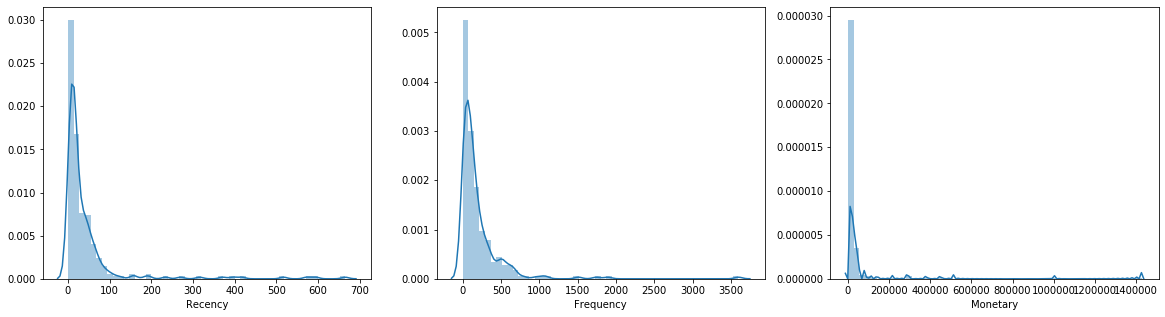

In [10]:
fig, axes = plt.subplots(1,3, figsize=(20,5))
for i, feature in enumerate(list(rfm_df.columns)):
    sns.distplot(rfm_df[feature], ax=axes[i])

In [11]:
display(rfm_df.describe())

,Recency,Frequency,Monetary
count,246.000000,246.000000,2.460000e+02
mean,44.495935,205.345528,3.046751e+04
std,90.426822,336.262796,1.237097e+05
min,1.000000,1.000000,2.671000e+01
25%,9.000000,42.250000,2.286433e+03
50%,16.000000,112.000000,5.780785e+03
75%,42.000000,233.250000,1.630086e+04
max,665.000000,3600.000000,1.425792e+06


Three plots for recency, frequency, and monetary value are showing obvious positive skewness. The assumption of symmetrical, constant mean and variance for model to be used, KMeans clutering, are not fulfilled. The data needs to be transformed. All of these three features are positive valued, and the transformations considered are square root, log, and box cox. The data are then vizualized to access the result of the transformation. 

#### Data Processing

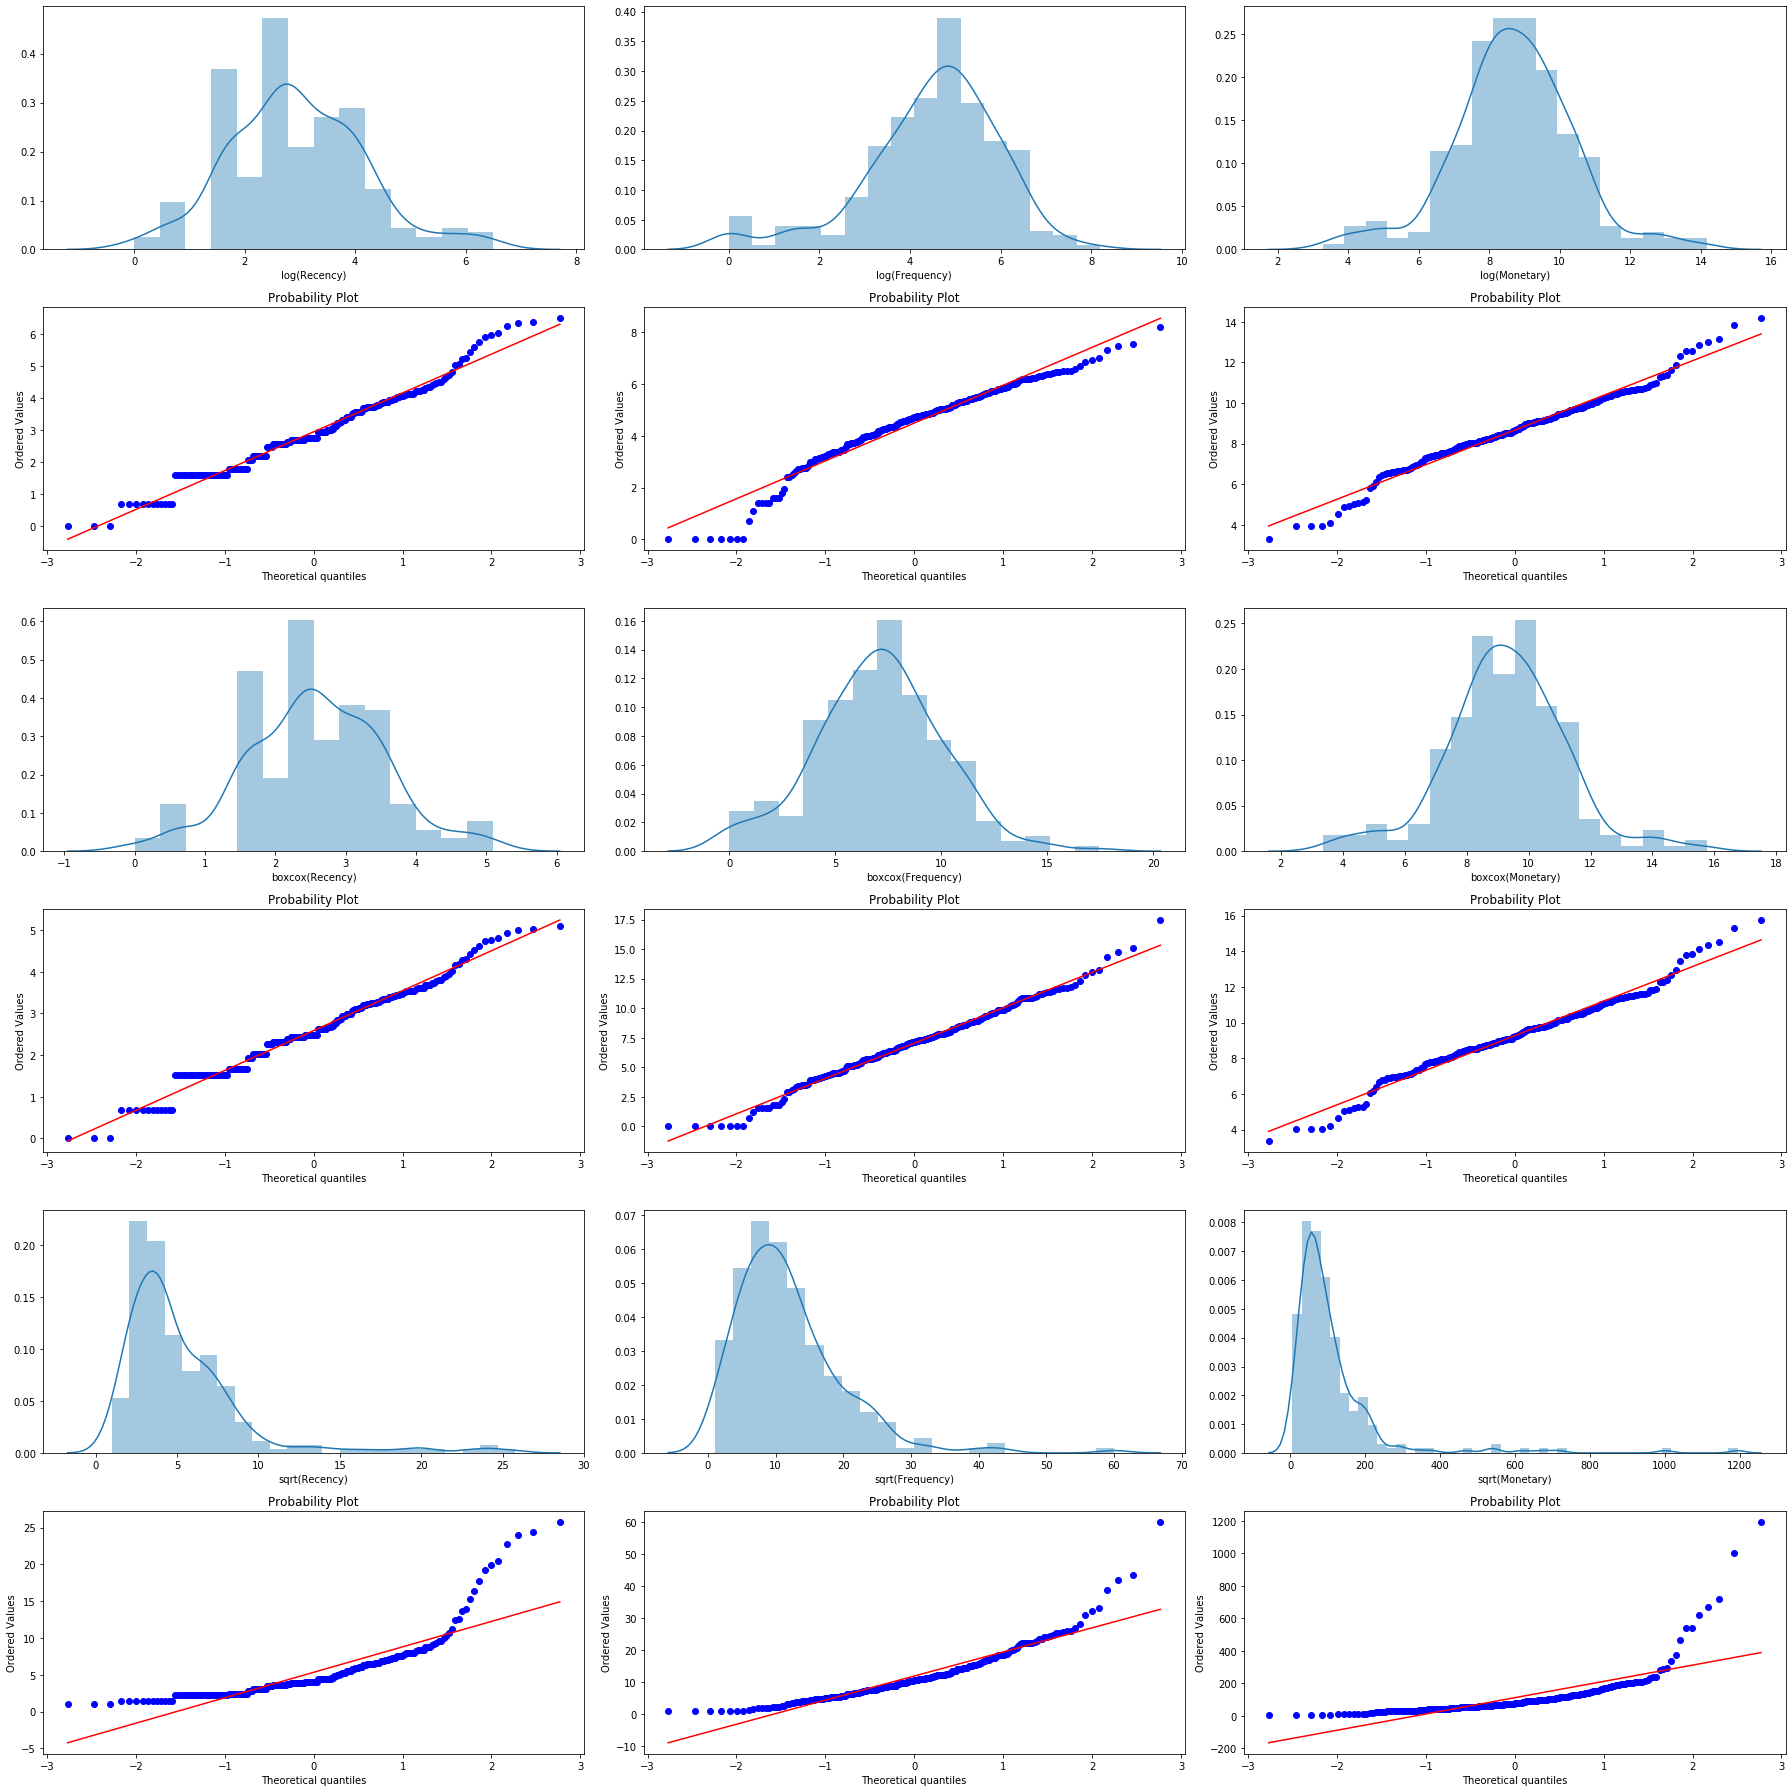

In [12]:
nrow, ncol = 6, 3
fig, axes = plt.subplots(nrow, ncol, figsize=(25,25))

for ind, rfm_feature in enumerate(list(rfm_df.columns)):
    
    sns.distplot(rfm_df[rfm_feature].apply(np.log), ax=axes[0,ind]).set(xlabel=f'log({rfm_feature})')
    sns.distplot(stats.boxcox(rfm_df[rfm_feature])[0], ax=axes[2,ind]).set(xlabel=f'boxcox({rfm_feature})')
    sns.distplot(rfm_df[rfm_feature].apply(np.sqrt), ax=axes[4,ind]).set(xlabel=f'sqrt({rfm_feature})')
    
    stats.probplot(rfm_df[rfm_feature].apply(np.log), dist=stats.norm, plot=axes[1,ind])
    stats.probplot(stats.boxcox(rfm_df[rfm_feature])[0], dist=stats.norm, plot=axes[3,ind])
    stats.probplot(rfm_df[rfm_feature].apply(np.sqrt), dist=stats.norm, plot=axes[5,ind])
fig.tight_layout()  

In [13]:
print('log transformation skewness: ')
print(rfm_df.apply(np.log).skew(axis = 0), '\n')

print('square root transformation skewness: ')
print(rfm_df.apply(np.sqrt).skew(axis = 0), '\n')

print('boxcox transformation skewness: ')
print('Recency\t', pd.Series(stats.boxcox(rfm_df['Recency'])[0]).skew(axis = 0))
print('Frequency\t', pd.Series(stats.boxcox(rfm_df['Recency'])[0]).skew(axis = 0))
print('Monetary\t', pd.Series(stats.boxcox(rfm_df['Recency'])[0]).skew(axis = 0), '\n')


log transformation skewness: 
Recency      0.316296
Frequency   -0.852262
Monetary    -0.110037
dtype: float64 

square root transformation skewness: 
Recency      2.643338
Frequency    1.824624
Monetary     4.600192
dtype: float64 

boxcox transformation skewness: 
Recency	 -0.006477859325092846
Frequency	 -0.006477859325092846
Monetary	 -0.006477859325092846 



In [14]:
for feature in list(rfm_df.columns):
    rfm_df[feature] = stats.boxcox(rfm_df[feature])[0]

scaler = StandardScaler()
rfm_normalized = pd.DataFrame(scaler.fit_transform(rfm_df))
rfm_normalized.columns = ['n_Recency', 'n_Frequency', 'n_Monetary']
rfm_normalized.describe()

,n_Recency,n_Frequency,n_Monetary
count,2.460000e+02,2.460000e+02,2.460000e+02
mean,-1.480297e-16,-2.650319e-16,-6.094944e-16
std,1.002039e+00,1.002039e+00,1.002039e+00
min,-2.706362e+00,-2.366142e+00,-3.041503e+00
25%,-5.965053e-01,-6.218155e-01,-5.562633e-01
50%,-1.016948e-01,4.064511e-02,-1.744004e-02
75%,6.795796e-01,6.149190e-01,5.936323e-01
max,2.613956e+00,3.496464e+00,3.337899e+00


In [15]:
display(rfm_normalized.head())

,n_Recency,n_Frequency,n_Monetary
0,-0.156089,1.317038,0.954484
1,0.199075,-1.183035,-1.167694
2,-0.596505,-0.217799,-0.270100
3,-0.156089,1.093199,0.452875
4,0.660785,0.585076,1.101126


Checking on the visualizations, the resulting plots for box cox ptransformation (row 3 and 4) are giving the best result on reducing the skewness. The is further supported by computing the skewness, box cox transformed data is giving the values that are closest to 0, they are said to be almost symmetry. The transformed data is standardized by computing Z-score, to ensure the mean and variance are constant over all the features. 

#### Modeling

Building a KMeans model to group the customers into different clusters. As number of centroids increases, sum of squared of distance between each of the centroids(SSE) and its members definitely decreases, and there comes a point where over-fitting incurres. Applying Elbow Method by plotting the SSE against k and locating the 'bend'. 

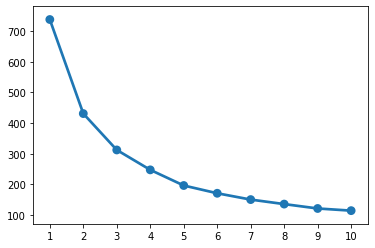

In [16]:
SSE = []
for k in range(0, 10):
    kmeans = KMeans(n_clusters=k+1, random_state=1231).fit(rfm_normalized)
    SSE.append(kmeans.inertia_)
    
sns.pointplot(x=list(range(1,11)), y=SSE)
plt.show()

The plot after k=4 is relatively linear, hence k is chosen as 4. 

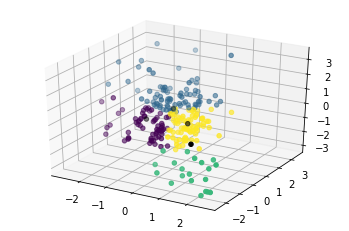

In [17]:
model = KMeans(n_clusters=4, random_state=1231).fit(rfm_normalized)
centers = model.cluster_centers_
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(rfm_normalized['n_Recency'], rfm_normalized['n_Frequency'],rfm_normalized['n_Monetary'], c=model.predict(rfm_normalized))
ax.scatter(centers[:, 0], centers[:, 1], c='black');

,n_Recency,n_Frequency,n_Monetary,Customer Id
0,-0.156089,1.317038,0.954484,98531
1,0.199075,-1.183035,-1.167694,98553
2,-0.596505,-0.217799,-0.270100,98568
3,-0.156089,1.093199,0.452875,98570
4,0.660785,0.585076,1.101126,98573


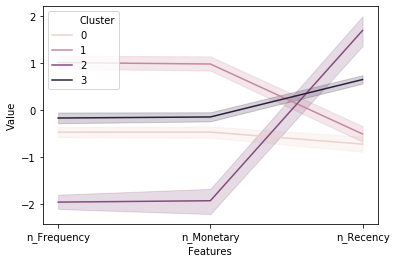

In [18]:
rfm_normalized['Customer Id'] = rfm_df.index
display(rfm_normalized.head())

rfm_normalized['Cluster'] = model.labels_
melted_rfm_normalized = pd.melt(rfm_normalized.reset_index(),
                      id_vars=['Customer Id', 'Cluster'],
                      value_vars=['n_Recency','n_Frequency','n_Monetary'],
                      var_name='Features',
                      value_name='Value')
sns.lineplot('Features', 'Value', hue='Cluster', data = melted_rfm_normalized)

In [19]:
rfm_df["Cluster"] = model.labels_
rfm_df.groupby('Cluster').agg({
    'Recency':['mean','min','max'],
    'Frequency':['mean','min','max'],
    'Monetary':['mean', 'min','max','count']})

Recency                      Frequency                       \
             mean       min       max       mean       min        max   
Cluster                                                                 
0        1.899543  0.000000  2.843543   5.658377  3.198654   8.558867   
1        2.105577  0.000000  3.600937  10.067522  6.342431  17.453782   
2        4.213003  2.778607  5.088072   1.223194  0.000000   3.420486   
3        3.213829  2.438947  4.312419   6.553529  2.946280  10.011251   

          Monetary                             
              mean       min        max count  
Cluster                                        
0         8.369190  6.763710  11.159959    64  
1        11.182577  9.616453  15.750696    81  
2         5.531112  3.365482   7.346359    20  
3         8.993485  6.406925  11.567599    81

In [20]:
customer_1 = rfm_normalized[(rfm_normalized.Cluster==1) & (rfm_normalized.n_Frequency>0) & (rfm_normalized.n_Monetary>0)].sort_values('n_Frequency')
customer_1.shape

(79, 5)

In [21]:
customer_2 = rfm_normalized[(rfm_normalized.Cluster==3) & (rfm_normalized.n_Frequency>0) & (rfm_normalized.n_Monetary>0)].sort_values('n_Frequency')
customer_2.shape

(23, 5)

In [22]:
customer_2 = customer_2.iloc[2:,]
target = pd.concat([customer_1, customer_2])
display(target.head())

goal_col = ['Customer Id', 'Customer Name']
acc_list = target.merge(data_cat[goal_col].drop_duplicates(), how='left')[goal_col]
display(acc_list.head())

acc_list.to_csv('C:/Users/Hshan/Desktop/account.csv', index=False)

,n_Recency,n_Frequency,n_Monetary,Customer Id,Cluster
11,-0.277686,0.097903,0.472459,98817,1
10,-0.596505,0.250619,0.442496,98805,1
48,-0.596505,0.266116,0.570331,100198,1
137,-0.700590,0.276305,0.629480,101283,1
214,-0.214543,0.286384,1.123341,115964,1


,Customer Id,Customer Name
0,98817,SOON
1,98805,HO
2,100198,POH
3,101283,THONG
4,115964,LUP



Observing the snake plot for all clusters, customers in cluster 1 purchase more often, spending more and have recently placing an order. The cluster 1 and 3 have the highest total number of orders throughout the period, but cluster 1 has higher purchasing frequency, at higher sales amount. It is the group of customers of our interest. 
Nevertheless, cluster 1 has only 79 customers.

Among the remaining clusters, cluster 3 has the highest value for frequency and monetary value, which are close to their mean value. It will be the next best cluster to be reach out to. Since Supplier Ltd is aiming to find 100 accounts for Cc without much emphazing on the size of the deal, we are choosing the remaining 21 customers out of 23 from cluster 3 by omitting the one with comparatively lower frequency among the members. (Complete list in Excel file 'account.csv')

Choosing the day after the last transaction was made (31 Dec 2019) as the point of analyzing, the most recent purchased were made in less than a week (covering a range of 2-4 days for each clusters) before the last transaction day, and it is sales data for only a period of two years,there is no churned customer or low possibility of purchasing for recent customers to be considered. Therefore, recency is not worth for too much attention. 


In [23]:
os.system('jupyter nbconvert --to html prework.ipynb')

0